## Extracting edge level tree features 🌳
This notebook details the process of extracting edge level tree features. It contains:
- [Data](#data)
- [Processing](#processing---extracting-edge-level-tree-attributes)
- [Exporting data](#dump-data)

In [1]:
import pandas as pd
import requests
from shapely import wkt
from shapely.geometry import Polygon, LineString
import matplotlib.pyplot as plt
import contextily as cx
import geopandas as gpd
import numpy as np
from tqdm import tqdm
import os
import time
from contextlib import ContextDecorator
from multiprocessing import Process, Queue
import osmnx as ox
import networkx as nx
import spaghetti
import matplotlib.colors
import seaborn as sns
from collections import Counter

/opt/conda/lib/python3.9/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


## Data
### Trees
Start by loading in the trees dataset. This data comes from [Open Data DK](https://www.opendata.dk/city-of-copenhagen/trae-basis-kommunale-traeer#resource-traer_basis.csv), and contains all municipal trees on municipal roads in Copenhagen Municipality.

In [2]:
df = pd.read_csv("../data/raw/Trees.csv")

/tmp/ipykernel_642/1632850283.py:1: DtypeWarning: Columns (53,59,60,61,62,74,76,77,81,83,85,88,91,95,101,129,147,148,149,168,169,170,186,187,188,189,190,191,192,193) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Trees.csv")#../data/raw/


In [3]:
df

,FID,uuid,id,kategori,saerligt_trae,type,element,under_element,ny_dm_element,ny_dm_under_element,...,r_img15,torso_hoejde,torso_omkreds,torso_stamme,torso_sidst_stynet,torso_frekvens_styning,torso_naeste_styning,torso_skaeres_ned_til,torso_bemaerkning,wkb_geometry
0,trae_basis.1,a09bd36c-7864-4f0d-97ce-44ec42eec643,2667,gadetræ,nej,2 Træer,2.2 Specialformede træer,2.2.2 Knudebeskårne træer,Formede træer,Knudebeskåret træ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (12.539616769956641 55.66532653220765)
1,trae_basis.2,0f738310-ec01-4dea-8164-e0b87b463a5a,2669,gadetræ,nej,2 Træer,2.2 Specialformede træer,2.2.2 Knudebeskårne træer,Formede træer,Knudebeskåret træ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (12.53965126748055 55.665390541095235)
2,trae_basis.3,938d7fae-9115-4e69-9290-3731e025d208,2676,gadetræ,nej,2 Træer,2.2 Specialformede træer,2.2.2 Knudebeskårne træer,Formede træer,Knudebeskåret træ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (12.539874779132376 55.66580513321524)
3,trae_basis.4,c05a9944-b17d-49c8-9c01-e46acca66129,2680,gadetræ,nej,2 Træer,2.1 Fuldkronede gade- og torvetræer,2.1.1 Gadetræer,Gade- og allétræer,Allétræ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (12.540025124286569 55.66608616293556)
4,trae_basis.5,84f73fb1-0783-443f-8caa-2ef7941b2bbb,2681,gadetræ,nej,2 Træer,2.2 Specialformede træer,2.2.2 Knudebeskårne træer,Formede træer,Knudebeskåret træ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (12.540060893478296 55.666150375833226)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64500,trae_basis.64501,d0cb241f-7a78-4717-9759-3e49b1041e1f,40439,parktræ,nej,2 Træer,2.3 Parktræer,NaN,Park- og naturtræer,Parktræ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (12.639966830590264 55.650495149618195)
64501,trae_basis.64502,26d4db76-b712-4e5e-8f11-403839b2e5ca,40440,parktræ,nej,2 Træer,2.3 Parktræer,NaN,Park- og naturtræer,Parktræ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (12.639981798991341 55.65046627705572)
64502,trae_basis.64503,b3fbc5b0-3700-4e34-a484-91f3b9e604f5,40441,parktræ,nej,2 Træer,2.3 Parktræer,NaN,Park- og naturtræer,Parktræ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (12.64038929927862 55.650082789824744)
64503,trae_basis.64504,7ebc1f8d-faad-4636-9ddd-fdc6770a7078,40452,parktræ,nej,2 Træer,2.3 Parktræer,NaN,Park- og naturtræer,Parktræ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (12.639912778720891 55.65055383939241)


We process this data using `GeoPandas`.

In [4]:
df["Coordinates"] = gpd.GeoSeries.from_wkt(df["wkb_geometry"])

We use CRS _EPSG:25832_ to work with coordinates in metric units.

In [5]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates", crs='EPSG:4326')

In [6]:
gdf

,FID,uuid,id,kategori,saerligt_trae,type,element,under_element,ny_dm_element,ny_dm_under_element,...,torso_hoejde,torso_omkreds,torso_stamme,torso_sidst_stynet,torso_frekvens_styning,torso_naeste_styning,torso_skaeres_ned_til,torso_bemaerkning,wkb_geometry,Coordinates
0,trae_basis.1,a09bd36c-7864-4f0d-97ce-44ec42eec643,2667,gadetræ,nej,2 Træer,2.2 Specialformede træer,2.2.2 Knudebeskårne træer,Formede træer,Knudebeskåret træ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (12.539616769956641 55.66532653220765),POINT (12.53962 55.66533)
1,trae_basis.2,0f738310-ec01-4dea-8164-e0b87b463a5a,2669,gadetræ,nej,2 Træer,2.2 Specialformede træer,2.2.2 Knudebeskårne træer,Formede træer,Knudebeskåret træ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (12.53965126748055 55.665390541095235),POINT (12.53965 55.66539)
2,trae_basis.3,938d7fae-9115-4e69-9290-3731e025d208,2676,gadetræ,nej,2 Træer,2.2 Specialformede træer,2.2.2 Knudebeskårne træer,Formede træer,Knudebeskåret træ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (12.539874779132376 55.66580513321524),POINT (12.53987 55.66581)
3,trae_basis.4,c05a9944-b17d-49c8-9c01-e46acca66129,2680,gadetræ,nej,2 Træer,2.1 Fuldkronede gade- og torvetræer,2.1.1 Gadetræer,Gade- og allétræer,Allétræ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (12.540025124286569 55.66608616293556),POINT (12.54003 55.66609)
4,trae_basis.5,84f73fb1-0783-443f-8caa-2ef7941b2bbb,2681,gadetræ,nej,2 Træer,2.2 Specialformede træer,2.2.2 Knudebeskårne træer,Formede træer,Knudebeskåret træ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (12.540060893478296 55.666150375833226),POINT (12.54006 55.66615)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64500,trae_basis.64501,d0cb241f-7a78-4717-9759-3e49b1041e1f,40439,parktræ,nej,2 Træer,2.3 Parktræer,NaN,Park- og naturtræer,Parktræ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (12.639966830590264 55.650495149618195),POINT (12.63997 55.65050)
64501,trae_basis.64502,26d4db76-b712-4e5e-8f11-403839b2e5ca,40440,parktræ,nej,2 Træer,2.3 Parktræer,NaN,Park- og naturtræer,Parktræ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (12.639981798991341 55.65046627705572),POINT (12.63998 55.65047)
64502,trae_basis.64503,b3fbc5b0-3700-4e34-a484-91f3b9e604f5,40441,parktræ,nej,2 Træer,2.3 Parktræer,NaN,Park- og naturtræer,Parktræ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (12.64038929927862 55.650082789824744),POINT (12.64039 55.65008)
64503,trae_basis.64504,7ebc1f8d-faad-4636-9ddd-fdc6770a7078,40452,parktræ,nej,2 Træer,2.3 Parktræer,NaN,Park- og naturtræer,Parktræ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (12.639912778720891 55.65055383939241),POINT (12.63991 55.65055)


We can visualize the wrangled trees data as a scatter plot, which gives:

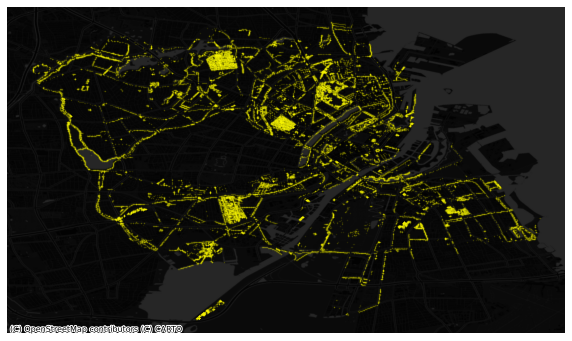

In [7]:
f, ax = plt.subplots(figsize=(10,10))
gdf.plot(
    markersize=0.25,
    c="xkcd:bright yellow",
    alpha=0.1,
    ax=ax)
# cph.plot(ax=ax, column='name', alpha=.2)
cx.add_basemap(source=cx.providers.CartoDB.DarkMatterNoLabels, crs=gdf.crs, ax=ax)
ax.set_axis_off()

### Bike paths
To get the bike paths, we use _OpenStreetMap_ with the library `osmnx`. We query OSM with the _Københavns Kommune_ geocode. We specify `network_type='bike'` to strictly get bike paths.

In [8]:
geocodes = ['Københavns Kommune']
G = ox.graph_from_place(geocodes, network_type='bike')
G = ox.project_graph(G, to_crs='EPSG:25832')

/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


Visualized, the bike path network looks like:

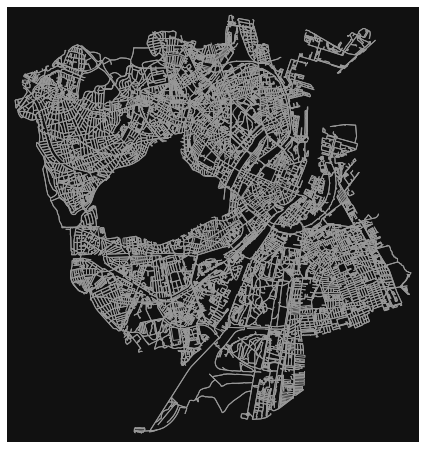

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [9]:
ox.plot_graph(G, node_size=0)

We convert to CRS _EPSG:25832_

In [10]:
gdf = gdf.to_crs('EPSG:25832')

## Processing - Extracting edge level tree attributes
Our approach to process this data for each tree, to find the nearest edge, and if the tree is within 10 meters keep it, and then count the number of trees attached to each edge.

In [11]:
# map each tree to nearest bike path and count trees per bike path
x = gdf.geometry.x.to_list()
y = gdf.geometry.y.to_list()
ne, dist = ox.nearest_edges(G, x, y, return_dist = 'true')

In [12]:
len(ne)

64505

In [13]:
for i in range(len(ne)):
    if dist[i]>10:
        ne[i] = np.nan

In [14]:
ne = [x for x in ne if str(x) != 'nan']

In [15]:
len(ne)

30097

In [16]:
cnt = Counter()
for edge in ne:
    cnt[edge] += 1

In [17]:
# use tree count as edge attribute
nx.set_edge_attributes(G, cnt, 'trees')

We also convert the network to `GeoDataFrame` enabling GeoPandas methods.

In [18]:
# convert graph to geodataframe
_, edges = ox.graph_to_gdfs(G)

In [19]:
edges

osmid  oneway  \
u           v           key                                    
118725      298795432   0                   27226011    True   
            6357644306  0                  140412993    True   
298795432   298795496   0                  244360867    True   
6357644306  2378383724  0                  678991574    True   
            6357644350  0                  679140293    True   
...                                              ...     ...   
11829253277 11829253278 0                 1273936398   False   
11886461653 11834934599 0                 1274613261   False   
            11834934657 0                 1280544121    True   
11837321069 11837321086 0    [1274879064, 327313131]   False   
11837321087 11837321086 0                 1274879069   False   

                                         name                 highway  \
u           v           key                                             
118725      298795432   0    Banegårdspladsen                tertiary   
            6357644306  0       Vesterbrogade                tertiary   
298795432   298795496   0    Banegårdspladsen                tertiary   
6357644306  2378383724  0       Vesterbrogade                tertiary   
            6357644350  0       Vesterbrogade                tertiary   
...                                       ...                     ...   
11829253277 11829253278 0                 NaN              pedestrian   
11886461653 11834934599 0                 NaN                cycleway   
            11834934657 0                 NaN                cycleway   
11837321069 11837321086 0          Grønvangen  [residential, service]   
11837321087 11837321086 0                 NaN                 service   

                            maxspeed   length  \
u           v           key                     
118725      298795432   0         30  112.872   
            6357644306  0         50   40.497   
298795432   298795496   0         30   89.801   
6357644306  2378383724  0         50   21.930   
            6357644350  0         50   23.056   
...                              ...      ...   
11829253277 11829253278 0        NaN   12.110   
11886461653 11834934599 0        NaN   19.362   
            11834934657 0        NaN   88.594   
11837321069 11837321086 0        NaN   21.964   
11837321087 11837321086 0        NaN   15.810   

                                                                      geometry  \
u           v           key                                                      
118725      298795432   0    LINESTRING (724025.025 6175551.339, 724031.889...   
            6357644306  0    LINESTRING (724025.025 6175551.339, 724051.956...   
298795432   298795496   0    LINESTRING (724075.369 6175450.104, 724076.732...   
6357644306  2378383724  0    LINESTRING (724059.919 6175572.112, 724075.704...   
            6357644350  0    LINESTRING (724059.919 6175572.112, 724081.508...   
...                                                                        ...   
11829253277 11829253278 0    LINESTRING (724148.784 6175265.946, 724160.933...   
11886461653 11834934599 0    LINESTRING (723790.304 6174588.639, 723792.301...   
            11834934657 0    LINESTRING (723790.304 6174588.639, 723782.760...   
11837321069 11837321086 0    LINESTRING (719712.098 6176675.435, 719709.131...   
11837321087 11837321086 0    LINESTRING (719714.233 6176647.233, 719722.203...   

                            lanes bridge  ref  trees        service width  \
u           v           key                                                 
118725      298795432   0     NaN    NaN  NaN    NaN            NaN   NaN   
            6357644306  0       2    NaN  NaN    NaN            NaN   NaN   
298795432   298795496   0     NaN    NaN  NaN    NaN            NaN   NaN   
6357644306  2378383724  0       2    NaN  NaN    NaN            NaN   NaN   
            6357644350  0       1    NaN  NaN    NaN            NaN   NaN   
...                 

In [20]:
# impute 0 on paths with no trees
edges['trees'] = edges['trees'].fillna(0)

We can plot this to see the bike paths with more trees.

/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


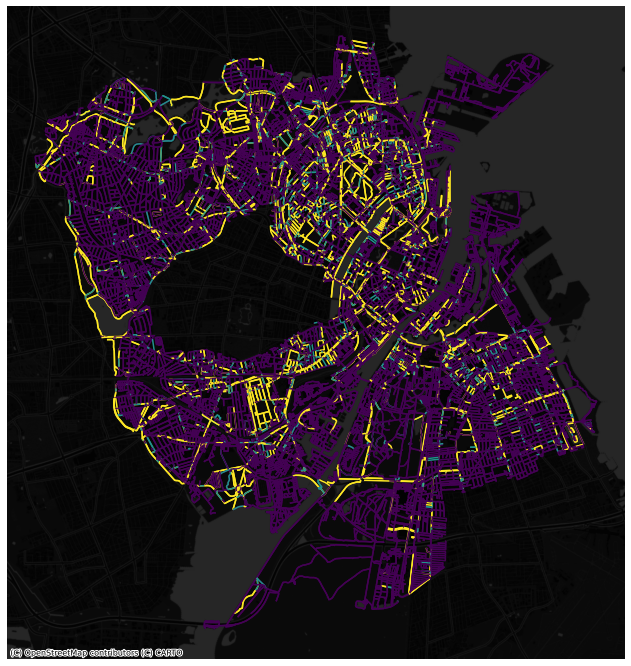

In [21]:
# plot bike paths with trees
f, ax = plt.subplots(figsize=(12,12))
edges.plot(
    column='trees',
    scheme='quantiles',
    k=10,
    ax=ax)
ax.set_axis_off()
cx.add_basemap(
    ax, 
    crs=edges.crs,
    source=cx.providers.CartoDB.DarkMatterNoLabels
)

Since some bike paths are longer than others, we normalize tree counts by path length.

In [22]:
edges['trees_per_m'] = edges['trees'] / edges['length']

Once processed, the wrangled data looks like:

In [23]:
edges

osmid  oneway  \
u           v           key                                    
118725      298795432   0                   27226011    True   
            6357644306  0                  140412993    True   
298795432   298795496   0                  244360867    True   
6357644306  2378383724  0                  678991574    True   
            6357644350  0                  679140293    True   
...                                              ...     ...   
11829253277 11829253278 0                 1273936398   False   
11886461653 11834934599 0                 1274613261   False   
            11834934657 0                 1280544121    True   
11837321069 11837321086 0    [1274879064, 327313131]   False   
11837321087 11837321086 0                 1274879069   False   

                                         name                 highway  \
u           v           key                                             
118725      298795432   0    Banegårdspladsen                tertiary   
            6357644306  0       Vesterbrogade                tertiary   
298795432   298795496   0    Banegårdspladsen                tertiary   
6357644306  2378383724  0       Vesterbrogade                tertiary   
            6357644350  0       Vesterbrogade                tertiary   
...                                       ...                     ...   
11829253277 11829253278 0                 NaN              pedestrian   
11886461653 11834934599 0                 NaN                cycleway   
            11834934657 0                 NaN                cycleway   
11837321069 11837321086 0          Grønvangen  [residential, service]   
11837321087 11837321086 0                 NaN                 service   

                            maxspeed   length  \
u           v           key                     
118725      298795432   0         30  112.872   
            6357644306  0         50   40.497   
298795432   298795496   0         30   89.801   
6357644306  2378383724  0         50   21.930   
            6357644350  0         50   23.056   
...                              ...      ...   
11829253277 11829253278 0        NaN   12.110   
11886461653 11834934599 0        NaN   19.362   
            11834934657 0        NaN   88.594   
11837321069 11837321086 0        NaN   21.964   
11837321087 11837321086 0        NaN   15.810   

                                                                      geometry  \
u           v           key                                                      
118725      298795432   0    LINESTRING (724025.025 6175551.339, 724031.889...   
            6357644306  0    LINESTRING (724025.025 6175551.339, 724051.956...   
298795432   298795496   0    LINESTRING (724075.369 6175450.104, 724076.732...   
6357644306  2378383724  0    LINESTRING (724059.919 6175572.112, 724075.704...   
            6357644350  0    LINESTRING (724059.919 6175572.112, 724081.508...   
...                                                                        ...   
11829253277 11829253278 0    LINESTRING (724148.784 6175265.946, 724160.933...   
11886461653 11834934599 0    LINESTRING (723790.304 6174588.639, 723792.301...   
            11834934657 0    LINESTRING (723790.304 6174588.639, 723782.760...   
11837321069 11837321086 0    LINESTRING (719712.098 6176675.435, 719709.131...   
11837321087 11837321086 0    LINESTRING (719714.233 6176647.233, 719722.203...   

                            lanes bridge  ref  trees        service width  \
u           v           key                                                 
118725      298795432   0     NaN    NaN  NaN    0.0            NaN   NaN   
            6357644306  0       2    NaN  NaN    0.0            NaN   NaN   
298795432   298795496   0     NaN    NaN  NaN    0.0            NaN   NaN   
6357644306  2378383724  0       2    NaN  NaN    0.0            NaN   NaN   
            6357644350  0       1    NaN  NaN    0.0            NaN   NaN   
...                 

## Dump data
Once the data is processed, we output it for further use of hygge analysis.

In [24]:
trees = edges.reset_index()

In [25]:
dump = trees[["u", "v", "key", "trees", "trees_per_m"]]

In [26]:
dump.head()

,u,v,key,trees,trees_per_m
0,118725,298795432,0,0.0,0.0
1,118725,6357644306,0,0.0,0.0
2,298795432,298795496,0,0.0,0.0
3,6357644306,2378383724,0,0.0,0.0
4,6357644306,6357644350,0,0.0,0.0


Output the data to a .csv

In [27]:
dump.to_csv('../data/tree_edges.csv', index=False)